In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('source/FReDA3.csv')
df2 = pd.read_csv('source/FReDA4.csv')

In [3]:
# ensure ordered categorical
df2['Perception'] = pd.Categorical(
    df2['Perception'],
    # categories=['Deprived', 'Satisfied', 'Saturated'],
    categories=['Saturated', 'Satisfied', 'Deprived'],
    ordered=True
)

# reshape: one row per dyad, one column per role
wide = (
    df2
    .pivot(index='CoupleId', columns='Role', values='Perception')
    .rename(columns={
        'Anchor': 'Anchor Perception',
        'Partner': 'Partner Perception'
    })
)

# absolute counts
crosstab = pd.crosstab(
    wide['Anchor Perception'],
    wide['Partner Perception']
)

# percentages of total
crosstab_pct = pd.crosstab(
    wide['Anchor Perception'],
    wide['Partner Perception'],
    normalize='all'
) * 100

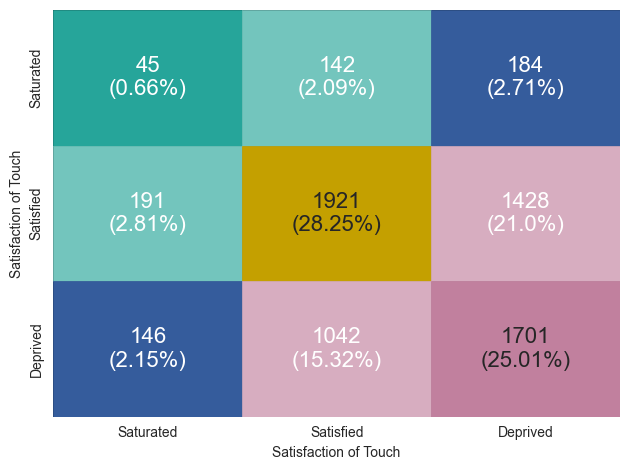

In [4]:
annot = crosstab.astype(str) + "\n(" + crosstab_pct.round(2).astype(str) + "%)"

cell_colors = np.array([
    # ['#c1809e', '#d7adc0', '#355C9C'],
    # ['#d7adc0', '#C4A000', '#73c5bd'],
    # ['#355C9C', '#73c5bd', '#26a59a']
    ['#26a59a', '#73c5bd', '#355C9C'],
    ['#73c5bd', '#C4A000', '#d7adc0'],
    ['#355C9C', '#d7adc0', '#c1809e']
])

colours2 = ['#C4A000',
            '#c1809e',
            '#d7adc0',
            '#26a59a',
            '#73c5bd',
            '#355C9C']

fig, ax = plt.subplots()
sns.heatmap(
    data=crosstab,
    # annot=True,
    annot=annot,
    # fmt='d',
    fmt='',
    cbar=False,
    annot_kws={"fontsize": 16},
    linewidths=0.5,
    linecolor='black',
)
# Set the facecolor of each cell
for i in range(crosstab.shape[0]):
    for j in range(crosstab.shape[1]):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=cell_colors[i, j], edgecolor='black', lw=0.5))

plt.xlabel("Satisfaction of Touch")
plt.ylabel("Satisfaction of Touch")
plt.tight_layout()
# plt.savefig('output/img/poster/divergence3.png', dpi=600, transparent=False, bbox_inches='tight')

CORRELATION MAPS

In [5]:
df2.loc[(df2['Kids'] == 0), "Kids binary"] = 0
df2.loc[(df2['Kids'] >= 1), "Kids binary"] = 1

couples_satisfied = df2[df2["Group3"] == "Couple Satisfaction"].copy()
couples_deprived = df2[df2["Group3"] == "Couple Deprivation"].copy()
couples_saturated = df2[df2["Group3"] == "Couple Saturation"].copy()
couples_mixed = df2[df2["Group3"] == "Couple Mixed"].copy()

In [6]:
# 1. Identify your columns (adjust names to match your exact CSV/DataFrame)
# I'm assuming names like 'Anchor Frequency' and 'Partner Frequency'
items = ['Frequency', 'Kiss Frequency', 'Hold Frequency', 'Hug Frequency',
         'Desire', 'Kiss Desire', 'Hold Desire', 'Hug Desire']

# 2. Create 'Side A' (Anchor is the primary)
side_a = df[['Id'] + [f'Anchor {i}' for i in items] + [f'Partner {i}' for i in items]].copy()
side_a.columns = ['Couple_ID'] + [f'Self_{i}' for i in items] + [f'Partner_{i}' for i in items]

# 3. Create 'Side B' (Partner is the primary)
side_b = df[['Id'] + [f'Partner {i}' for i in items] + [f'Anchor {i}' for i in items]].copy()
side_b.columns = ['Couple_ID'] + [f'Self_{i}' for i in items] + [f'Partner_{i}' for i in items]

# 4. The Merge: This creates the "Repeated Measures" long-format structure
df_long = pd.concat([side_a, side_b], ignore_index=True)

In [7]:
# Select all Self and Partner columns to center
cols_to_center = [c for c in df_long.columns if 'Self_' in c or 'Partner_' in c]

# Calculate the mean for each couple ID
couple_means = df_long.groupby('Couple_ID')[cols_to_center].transform('mean')

# Center the data: (Actual Value - Couple Mean)
df_centered = df_long[cols_to_center] - couple_means

In [5]:
results = []
# Match Frequency items to their corresponding Desire items
categories = ['Frequency', 'Kiss Frequency', 'Hold Frequency', 'Hug Frequency']

for cat in categories:
    freq_col = f'Self_{cat}'
    # Mapping 'Frequency' to 'Desire'
    desire_col = freq_col.replace('Frequency', 'Desire')

    # Calculate Spearman Correlation on the centered data
    r_val, p_val = stats.spearmanr(df_centered[freq_col], df_centered[desire_col])

    results.append({
        'Touch Type': cat.replace(' Frequency', '') or 'Overall',
        'Spearman r (rm)': round(r_val, 3),
        'p-value': '< .001' if p_val < .001 else round(p_val, 4)
    })

# Final Table
table_output = pd.DataFrame(results)
print(table_output)

  Touch Type  Spearman r (rm) p-value
0  Frequency            0.677  < .001
1       Kiss            0.616  < .001
2       Hold            0.733  < .001
3        Hug            0.685  < .001


In [8]:
touch_factors = [
    'Frequency',
    'Desire',
]

individual_factors = [
    'Sex',
    'Age',
    'Work Status',
    'Urbanization',
    'Education',
    'Region'

]

personality_factors = [
    'Neuroticism',
    'Extraversion',
    'Conscientiousness',
    'Openness',
    'Agreeableness',
]

wellbeing_factors = [
    'Depressiveness',
    'Loneliness',
    'Self-esteem',
    'Life Satisfaction',
    'Health',
]

relationship_factors = [
    'Relationship Length',
    'Age difference',
    'Married',
    'Cohabitation',
    'Kids',

    'Relationship Satisfaction',
    'Communication Quality',
    'Conflict Management',
]

In [10]:
correlation = df2[
    touch_factors +
    individual_factors +
    personality_factors +
    wellbeing_factors +
    relationship_factors
    ].corr(method='spearman')

num_vars = len(correlation.columns)
square_size = 1  # in inches, per cell

fig_width = num_vars * square_size
fig_height = num_vars * square_size

# plt.figure(figsize=(fig_width, fig_height))

# sns.heatmap(correlation, cmap='YlGnBu',
#             fmt='.2f',
#             linewidths=0.5,
#             vmax=0.5,
#             vmin=-0.5,
#             annot_kws={"size": 10},
#             annot=True,
#             square=True
#             )

# plt.grid(False)
# plt.savefig('output/img/poster/correlation.png', dpi=600, transparent=False, bbox_inches='tight')

In [11]:
cols = touch_factors + individual_factors + personality_factors + wellbeing_factors + relationship_factors

# Initialize matrices for correlation and p-values
corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
pval_matrix = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

# Fill in the matrices
for i in range(len(cols)):
    for j in range(i, len(cols)):
        col1 = cols[i]
        col2 = cols[j]
        r, p = spearmanr(df2[col1], df2[col2], nan_policy='omit')
        corr_matrix.loc[col1, col2] = r
        corr_matrix.loc[col2, col1] = r
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p

In [12]:
from scipy.stats import chi2_contingency

# Difference by sex in Frequency?
# hypothesis test of independence of the observed frequencies
contingency = pd.crosstab(df2['Couple Frequency'], df2['Couple Desire'])
res = chi2_contingency(contingency)
print("--- Couple Touch ---")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")
# Chi Square contingency test suggest that there is a strong association between Frequency and Desire, as null hypothesis is rejected.

touch_factors = [
    'Anchor Frequency',
    'Anchor Desire',
    'Anchor Kiss Frequency',
    'Anchor Kiss Desire',
    "Anchor Hold Frequency",
    "Anchor Hold Desire",
    'Anchor Hug Frequency',
    'Anchor Hug Desire',
    'Partner Frequency',
    'Partner Desire',
    'Partner Kiss Frequency',
    'Partner Kiss Desire',
    "Partner Hold Frequency",
    "Partner Hold Desire",
    'Partner Hug Frequency',
    'Partner Hug Desire',
]

--- Couple Touch ---
Dof:900, Chi-square: 58481.05169715984, p-value: 0.0


In [44]:
def alpha_palette(hex_color, n=7, min_alpha=0.2, max_alpha=1.0, perceptual=True):
    rgb = mcolors.to_rgb(hex_color)

    if perceptual:
        alphas = np.geomspace(min_alpha, max_alpha, n)
    else:
        alphas = np.linspace(min_alpha, max_alpha, n)

    colors_map = [(rgb[0], rgb[1], rgb[2], a) for a in alphas]
    return ListedColormap(colors_map)


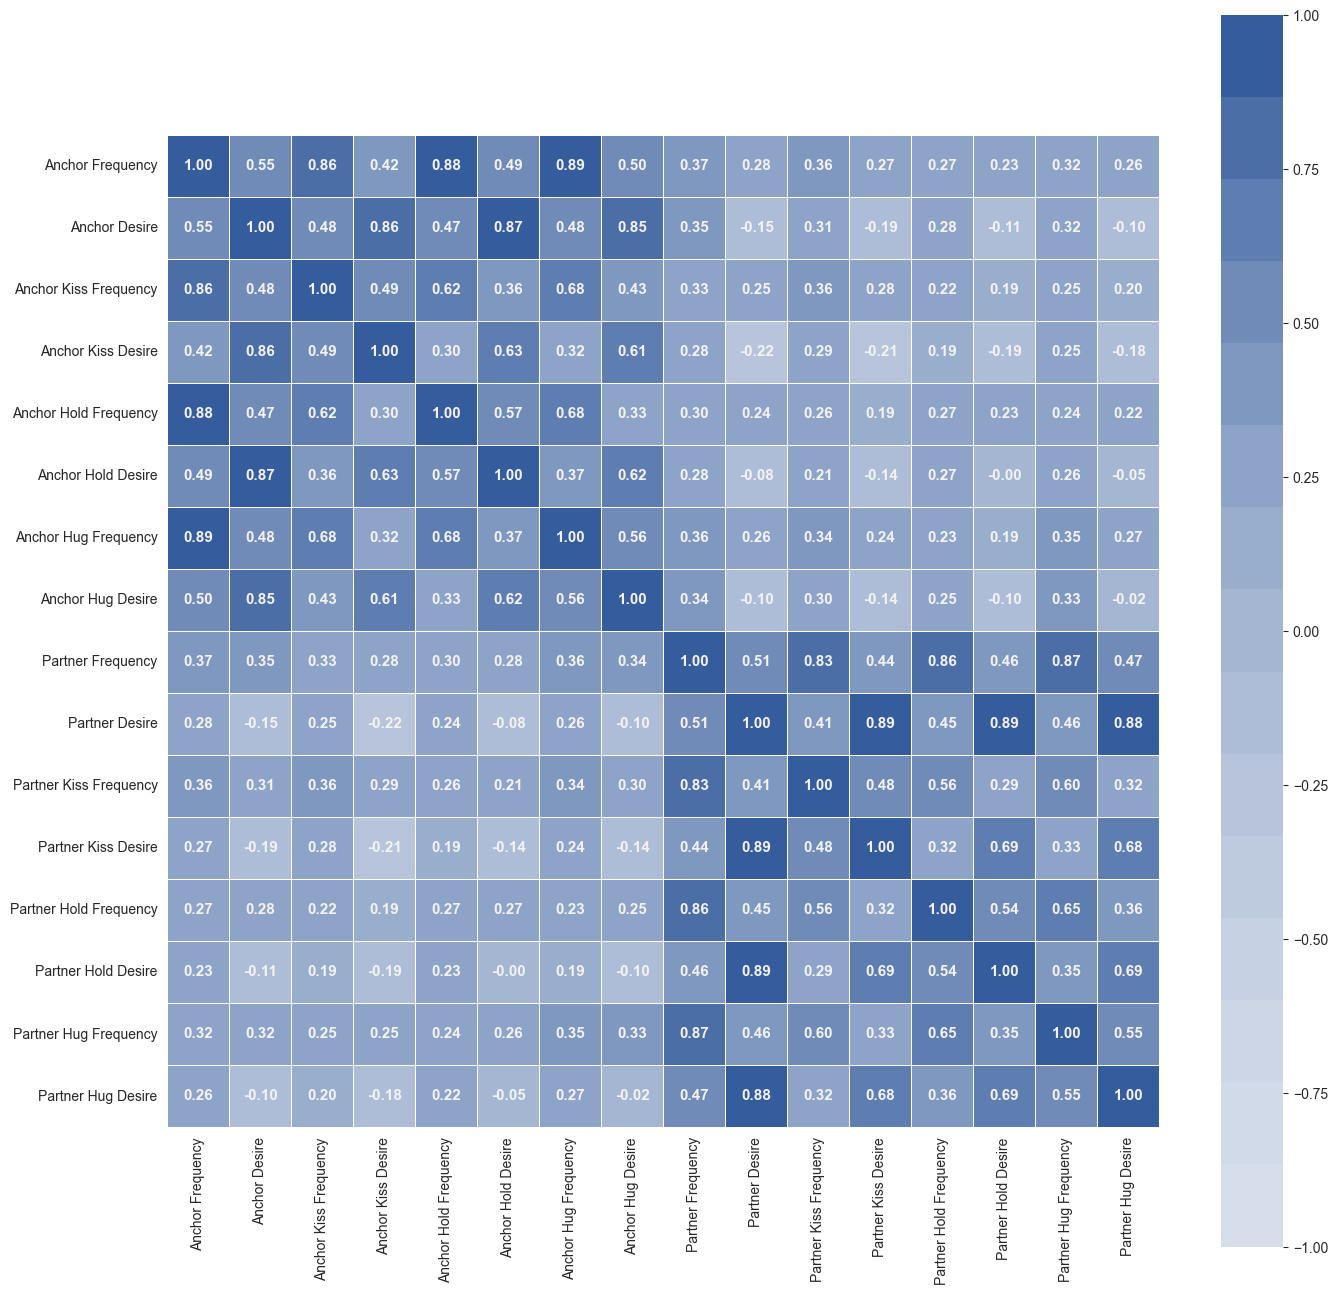

In [45]:
dfs = [
    couples_satisfied,
    couples_deprived,
    couples_saturated,
    couples_mixed
]

cols = ['#C4A000',
        '#c1809e',
        '#26a59a',
        '#355C9C']

fonts = ["#222222",
         "#222222",
         "#333333",
         "#F2F2F2"]

f = 3

target_df = dfs[f]
target_col = cols[f]
target_font = fonts[f]

cmap = alpha_palette(target_col, n=15)

correlation = target_df[
    touch_factors
].corr(method='spearman')

num_vars = len(correlation.columns)
square_size = 1

fig_width = num_vars * square_size
fig_height = num_vars * square_size

plt.figure(figsize=(fig_width, fig_height))

sns.heatmap(correlation,
            cmap=cmap,
            fmt='.2f',
            linewidths=0.5,
            vmax=1,
            vmin=-1,
            annot_kws={"size": 11,
                       "fontweight": "bold",
                       "color": target_font
                       },
            annot=True,
            square=True
            )
plt.grid(False)
# plt.savefig('output/img/correlation/correlation_mix.png', dpi=600, transparent=False, bbox_inches='tight')

column = touch_factors
# Initialize matrices for correlation and p-values
corr_matrix = pd.DataFrame(np.zeros((len(column), len(column))), columns=column, index=column)
pval_matrix = pd.DataFrame(np.ones((len(column), len(column))), columns=column, index=column)

# Fill in the matrices
for i in range(len(column)):
    for j in range(i, len(column)):
        col1 = column[i]
        col2 = column[j]
        r, p = spearmanr(target_df[col1], target_df[col2], nan_policy='omit')
        corr_matrix.loc[col1, col2] = r
        corr_matrix.loc[col2, col1] = r
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p


In [46]:
couples_satisfied = df2[df2["Group3"] == "Couple Satisfaction"].copy()
couples_deprived = df2[df2["Group3"] == "Couple Deprivation"].copy()
couples_saturated = df2[df2["Group3"] == "Couple Saturation"].copy()
couples_mixed = df2[df2["Group3"] == "Couple Mixed"].copy()

In [47]:
drop = True

count_base = couples_satisfied['Work Status'].value_counts(dropna=drop)
count_d = couples_deprived['Work Status'].value_counts(dropna=drop)
count_s = couples_saturated['Work Status'].value_counts(dropna=drop)
count_m = couples_mixed['Work Status'].value_counts(dropna=drop)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    # 'Saturated': count_s,
    # 'Mixed': count_m,
})

print(contingency)
res = chi2_contingency(contingency)
chi_stat = res[0]

# Performing Cramer's V calculation
# Size of the sample
N = contingency.to_numpy().sum()
# Minimum dimension
minimum_dimension = (min(contingency.shape)-1)

# Calculate Cramer's V
r, k = contingency.shape
result = np.sqrt(chi_stat / (N * (min(r-1, k-1))))

chi2, p, dof, expected = chi2_contingency(contingency)
(expected < 5).sum()
n_violations = (expected < 5).sum()
total_cells = expected.size

print(f"Cells with expected count < 5: {n_violations}/{total_cells}")
print(f"Percentage: {100 * n_violations / total_cells:.1f}%")
print(f"Cramer's V: {result}")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

             Satisfied  Deprived
Work Status                     
2.0               2902      5460
1.0                595      1783
0.0                306      1000
Cells with expected count < 5: 0/6
Percentage: 0.0%
Cramer's V: 0.10198709026052775
Dof:2, Chi-square: 125.29486182037965, p-value: 6.202495391914086e-28


In [48]:
drop = False
count_base = couples_satisfied['Urbanization'].value_counts(dropna=drop)
count_d = couples_deprived['Urbanization'].value_counts(dropna=drop)
count_s = couples_saturated['Urbanization'].value_counts(dropna=drop)
count_m = couples_mixed['Urbanization'].value_counts(dropna=drop)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    'Saturated': count_s,
    'Mixed': count_m,
})


print(contingency)
res = chi2_contingency(contingency)
chi_stat = res[0]

# Performing Cramer's V calculation
# Size of the sample
N = contingency.to_numpy().sum()
# Minimum dimension
minimum_dimension = (min(contingency.shape)-1)

# Calculate Cramer's V
r, k = contingency.shape
result = np.sqrt(chi_stat / (N * (min(r-1, k-1))))

chi2, p, dof, expected = chi2_contingency(contingency)
(expected < 5).sum()
n_violations = (expected < 5).sum()
total_cells = expected.size

print(f"Cells with expected count < 5: {n_violations}/{total_cells}")
print(f"Percentage: {100 * n_violations / total_cells:.1f}%")
print(f"Cramer's V: {result}")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

              Satisfied  Deprived  Saturated  Mixed
Urbanization                                       
0.0                 706      1643        140    105
1.0                1535      3451        278    242
2.0                1496      3027        318    288
NaN                 105       221         20     25
Cells with expected count < 5: 0/16
Percentage: 0.0%
Cramer's V: 0.027997372595242372
Dof:9, Chi-square: 31.98119718726261, p-value: 0.00020062430226554473


In [49]:
drop = True
count_base = couples_satisfied['Education'].value_counts(dropna=drop)
count_d = couples_deprived['Education'].value_counts(dropna=drop)
count_s = couples_saturated['Education'].value_counts(dropna=drop)
count_m = couples_mixed['Education'].value_counts(dropna=drop)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    # 'Deprived': count_d,
    # 'Saturated': count_s,
    'Mixed': count_m,
})

print(contingency)
res = chi2_contingency(contingency)
chi_stat = res[0]

# Performing Cramer's V calculation
# Size of the sample
N = contingency.to_numpy().sum()
# Minimum dimension
minimum_dimension = (min(contingency.shape)-1)

# Calculate Cramer's V
r, k = contingency.shape
result = np.sqrt(chi_stat / (N * (min(r-1, k-1))))

chi2, p, dof, expected = chi2_contingency(contingency)
(expected < 5).sum()
n_violations = (expected < 5).sum()
total_cells = expected.size

print(f"Cells with expected count < 5: {n_violations}/{total_cells}")
print(f"Percentage: {100 * n_violations / total_cells:.1f}%")
print(f"Cramer's V: {result}")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

           Satisfied  Mixed
Education                  
0.0               97      6
1.0               14      3
2.0               35     13
3.0              821    166
4.0              518    103
6.0             1207    178
7.0              697    118
8.0              139     24
Cells with expected count < 5: 1/16
Percentage: 6.2%
Cramer's V: 0.07202122188851828
Dof:7, Chi-square: 21.469226449182553, p-value: 0.0031343296963858135


In [50]:
drop = True
count_base = couples_satisfied['Kids binary'].value_counts(dropna=drop)
count_d = couples_deprived['Kids binary'].value_counts(dropna=drop)
count_s = couples_saturated['Kids binary'].value_counts(dropna=drop)
count_m = couples_mixed['Kids binary'].value_counts(dropna=drop)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    # 'Deprived': count_d,
    # 'Saturated': count_s,
    # 'Mixed': count_m,
})

print(contingency)
res = chi2_contingency(contingency)
chi_stat = res[0]

# Performing Cramer's V calculation
# Size of the sample
N = contingency.to_numpy().sum()
# Minimum dimension
minimum_dimension = (min(contingency.shape)-1)

# Calculate Cramer's V
r, k = contingency.shape
result = np.sqrt(chi_stat / (N * (min(r-1, k-1))))

chi2, p, dof, expected = chi2_contingency(contingency)
(expected < 5).sum()
n_violations = (expected < 5).sum()
total_cells = expected.size

print(f"Cells with expected count < 5: {n_violations}/{total_cells}")
print(f"Percentage: {100 * n_violations / total_cells:.1f}%")
print(f"Cramer's V: {result}")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

             Satisfied
Kids binary           
0.0               2124
1.0               1716
Cells with expected count < 5: 0/2
Percentage: 0.0%
Cramer's V: nan
Dof:0, Chi-square: 0.0, p-value: 1.0


In [51]:
count_base = couples_satisfied['Region'].value_counts(dropna=False)
count_d = couples_deprived['Region'].value_counts(dropna=False)
count_s = couples_saturated['Region'].value_counts(dropna=False)
count_m = couples_mixed['Region'].value_counts(dropna=False)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    # 'Saturated': count_s,
    # 'Mixed': count_m,
})

print(contingency)
res = chi2_contingency(contingency)
chi_stat = res[0]

# Performing Cramer's V calculation
# Size of the sample
N = contingency.to_numpy().sum()
# Minimum dimension
minimum_dimension = (min(contingency.shape)-1)

# Calculate Cramer's V
r, k = contingency.shape
result = np.sqrt(chi_stat / (N * (min(r-1, k-1))))

chi2, p, dof, expected = chi2_contingency(contingency)
(expected < 5).sum()
n_violations = (expected < 5).sum()
total_cells = expected.size

print(f"Cells with expected count < 5: {n_violations}/{total_cells}")
print(f"Percentage: {100 * n_violations / total_cells:.1f}%")
print(f"Cramer's V: {result}")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

        Satisfied  Deprived
Region                     
1.0          3210      6858
0.0           533      1273
NaN            99       211
Cells with expected count < 5: 0/6
Percentage: 0.0%
Cramer's V: 0.01814015824374786
Dof:2, Chi-square: 4.009332116062472, p-value: 0.13470527192907278


In [52]:
drop = True
count_base = couples_satisfied['Married'].value_counts(dropna=drop)
count_d = couples_deprived['Married'].value_counts(dropna=drop)
count_s = couples_saturated['Married'].value_counts(dropna=drop)
count_m = couples_mixed['Married'].value_counts(dropna=drop)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    # 'Saturated': count_s,
    # 'Mixed': count_m,
})

print(contingency)
res = chi2_contingency(contingency)
chi_stat = res[0]

# Performing Cramer's V calculation
# Size of the sample
N = contingency.to_numpy().sum()
# Minimum dimension
minimum_dimension = (min(contingency.shape)-1)

# Calculate Cramer's V
r, k = contingency.shape
result = np.sqrt(chi_stat / (N * (min(r-1, k-1))))

chi2, p, dof, expected = chi2_contingency(contingency)
(expected < 5).sum()
n_violations = (expected < 5).sum()
total_cells = expected.size

print(f"Cells with expected count < 5: {n_violations}/{total_cells}")
print(f"Percentage: {100 * n_violations / total_cells:.1f}%")
print(f"Cramer's V: {result}")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

         Satisfied  Deprived
Married                     
1.0           2216      5742
0.0           1626      2600
Cells with expected count < 5: 0/4
Percentage: 0.0%
Cramer's V: 0.10870304842848319
Dof:1, Chi-square: 143.97044175546864, p-value: 3.606229024265657e-33


In [53]:
drop = True
count_base = couples_satisfied['Cohabitation'].value_counts(dropna=drop)
count_d = couples_deprived['Cohabitation'].value_counts(dropna=drop)
count_s = couples_saturated['Cohabitation'].value_counts(dropna=drop)
count_m = couples_mixed['Cohabitation'].value_counts(dropna=drop)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    # 'Deprived': count_d,
    # 'Saturated': count_s,
    'Mixed': count_m,
})

print(contingency)
res = chi2_contingency(contingency)
chi_stat = res[0]

# Performing Cramer's V calculation
# Size of the sample
N = contingency.to_numpy().sum()
# Minimum dimension
minimum_dimension = (min(contingency.shape)-1)

# Calculate Cramer's V
r, k = contingency.shape
result = np.sqrt(chi_stat / (N * (min(r-1, k-1))))

chi2, p, dof, expected = chi2_contingency(contingency)
(expected < 5).sum()
n_violations = (expected < 5).sum()
total_cells = expected.size

print(f"Cells with expected count < 5: {n_violations}/{total_cells}")
print(f"Percentage: {100 * n_violations / total_cells:.1f}%")
print(f"Cramer's V: {result}")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

              Satisfied  Mixed
Cohabitation                  
1                  3434    600
0                   408     60
Cells with expected count < 5: 0/4
Percentage: 0.0%
Cramer's V: 0.016686237320495362
Dof:1, Chi-square: 1.2534941826533468, p-value: 0.2628861552168813


In [54]:
drop = True
count_base = couples_satisfied['Sex'].value_counts(dropna=drop)
count_d = couples_deprived['Sex'].value_counts(dropna=drop)
count_s = couples_saturated['Sex'].value_counts(dropna=drop)
count_m = couples_mixed['Sex'].value_counts(dropna=drop)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    # 'Deprived': count_d,
    # 'Saturated': count_s,
    'Mixed': count_m,
})

print(contingency)
res = chi2_contingency(contingency)
chi_stat = res[0]

# Performing Cramer's V calculation
# Size of the sample
N = contingency.to_numpy().sum()
# Minimum dimension
minimum_dimension = (min(contingency.shape)-1)

# Calculate Cramer's V
r, k = contingency.shape
result = np.sqrt(chi_stat / (N * (min(r-1, k-1))))

chi2, p, dof, expected = chi2_contingency(contingency)
(expected < 5).sum()
n_violations = (expected < 5).sum()
total_cells = expected.size

print(f"Cells with expected count < 5: {n_violations}/{total_cells}")
print(f"Percentage: {100 * n_violations / total_cells:.1f}%")
print(f"Cramer's V: {result}")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

     Satisfied  Mixed
Sex                  
0.0       1916    331
1.0       1918    328
Cells with expected count < 5: 0/4
Percentage: 0.0%
Cramer's V: 0.0011659593118967008
Dof:1, Chi-square: 0.006108058798674834, p-value: 0.9377054963235312


In [55]:
drop = True
count_base = couples_satisfied['Relationship Sex'].value_counts(dropna=drop)
count_d = couples_deprived['Relationship Sex'].value_counts(dropna=drop)
count_s = couples_saturated['Relationship Sex'].value_counts(dropna=drop)
count_m = couples_mixed['Relationship Sex'].value_counts(dropna=drop)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    # 'Deprived': count_d,
    # 'Saturated': count_s,
    'Mixed': count_m,
})

print(contingency)
res = chi2_contingency(contingency)
chi_stat = res[0]

# Performing Cramer's V calculation
# Size of the sample
N = contingency.to_numpy().sum()
# Minimum dimension
minimum_dimension = (min(contingency.shape)-1)

# Calculate Cramer's V
r, k = contingency.shape
result = np.sqrt(chi_stat / (N * (min(r-1, k-1))))

chi2, p, dof, expected = chi2_contingency(contingency)
(expected < 5).sum()
n_violations = (expected < 5).sum()
total_cells = expected.size

print(f"Cells with expected count < 5: {n_violations}/{total_cells}")
print(f"Percentage: {100 * n_violations / total_cells:.1f}%")
print(f"Cramer's V: {result}")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

                  Satisfied  Mixed
Relationship Sex                  
0                      3710    638
1                       132     22
Cells with expected count < 5: 0/4
Percentage: 0.0%
Cramer's V: 0.00026476667342426155
Dof:1, Chi-square: 0.0003155964638853853, p-value: 0.9858262984884236


In [56]:
count_base = couples_satisfied['Age']
count_d = couples_deprived['Age']
count_s = couples_saturated['Age']
count_m = couples_mixed['Age']

rvs1 = count_base
rvs2 = count_m

t, p = stats.ttest_ind(rvs1, rvs2, equal_var=False)
m1, sd1, n1 = rvs1.mean(), rvs1.std(ddof=1), len(rvs1)
m2, sd2, n2 = rvs2.mean(), rvs2.std(ddof=1), len(rvs2)
s1, s2 = sd1 ** 2, sd2 ** 2

df = (s1 / n1 + s2 / n2) ** 2 / (
        (s1 / n1) ** 2 / (n1 - 1) + (s2 / n2) ** 2 / (n2 - 1)
)
sd_pooled = np.sqrt((s1 + s2) / 2)
d = (m1 - m2) / sd_pooled


report = (
    # f"An independent-samples Welch’s t-test showed that "
    # f"Group A (M = {m1:.2f}, SD = {sd1:.2f}) scored higher than "
    # f"Group B (M = {m2:.2f}, SD = {sd2:.2f}), "
    f"t({df:.2f}) = {t:.2f}, p {p}, d = {d:.2f}."
)
print(report)

t(936.43) = -1.44, p 0.15142143056957713, d = -0.06.


In [57]:
rename_map = {
    'SubGroup1': 'Satisfied',
    'SubGroup2': 'Deprived_Me',
    'SubGroup3': 'Deprived_Couples',
    'SubGroup7': 'Deprived_Partner',
    'SubGroup5': 'Saturated_Me',
    'SubGroup6': 'Saturated_Couples',
    'SubGroup8': 'Saturated_Partner',
    'SubGroup4': 'Mixed_Couples',
    'SubGroup9': 'Mixed_Couples'
}

# rename_map = {
#     'SubGroup1': 'Satisfied',
#     'SubGroup2': 'Deprived_One',
#     'SubGroup3': 'Deprived_Couples',
#     'SubGroup7': 'Deprived_One',
#     'SubGroup5': 'Saturated_One',
#     'SubGroup6': 'Saturated_Couples',
#     'SubGroup8': 'Saturated_One',
#     'SubGroup4': 'Mixed_Couples',
#     'SubGroup9': 'Mixed_Couples'
# }

df2['Group1'] = df2['Group1'].replace(rename_map)

In [58]:
df2['Group1'].value_counts()

Group1
Satisfied            3842
Deprived_Couples     3402
Deprived_Partner     2856
Deprived_Me          2084
Mixed_Couples         660
Saturated_Partner     382
Saturated_Me          284
Saturated_Couples      90
Name: count, dtype: int64

In [59]:
traits = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
# traits = ['Depressiveness', 'Loneliness', 'Self-esteem', 'Life Satisfaction', 'Health']
# traits = ["Communication Quality", "Relationship Satisfaction", "Conflict Management"]

stats = (
    df2
    .groupby('Group1')[traits]
    .agg(['mean', 'std'])
)
print(stats)

                  Extraversion           Agreeableness            \
                          mean       std          mean       std   
Group1                                                             
Deprived_Couples      9.210387  2.024568     10.774080  2.001894   
Deprived_Me           9.329163  2.036127     10.998076  1.943870   
Deprived_Partner      9.284510  2.024407     10.947350  1.958318   
Mixed_Couples         9.254573  2.103609     10.803653  2.196752   
Satisfied             9.418908  2.052604     11.097650  1.951453   
Saturated_Couples    10.055556  2.035423     10.522222  2.214497   
Saturated_Me          9.384342  2.060245     10.996441  1.875592   
Saturated_Partner     9.513089  2.023117     11.089239  1.904956   

                  Conscientiousness           Neuroticism            \
                               mean       std        mean       std   
Group1                                                                
Deprived_Couples          10.928656  2